# Import Cell

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, NMF, DictionaryLearning
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.colors

import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
import os
import os.path
from matplotlib import cm
from scipy.signal import savgol_filter as sg
from scipy import interpolate
from matplotlib.colors import LogNorm
import matplotlib


# Instructions

1. Set global parameters <br>
       b. global_alp: A list of floats. Which alpha values do you want to try?
       c. save_path/add_in_save: Just where to save the figures etc.
2. Run all cells.

# Global Parameters

In [2]:
save_path = './'
global_alp = [1,6,12]
add_in_save = 'test'

path_to_data = './'

In [3]:
%matplotlib notebook

# References

[1]  J. C. Agar, Y. Cao, B. Naul, S. Pandya, S. van der Walt, A. I. Luo, J. T. Maher, N. Balke, S. Jesse,S. V. Kalinin, R. K. Vasudevan,  and L. W. Martin, Advanced Materials 30, 1800701 (2018). <br>
[2]  J. C. Agar, B. Naul, S. Pandya, S. van der Walt, J. Maher, Y. Ren, L.-Q. Chen, S. V. Kalinin, R. K.Vasudevan, Y. Cao, J. S. Bloom,  and L. W. Martin, Nature Communications 10, 4809 (2019)

# Import and Clean Their Data

Import the data with scipy, which provides functions for loading matlab files

In [3]:
# imports the raw band excitation data
imported = {'data': io.matlab.loadmat(path_to_data+'Data.mat'),
            'validation_data': io.matlab.loadmat(path_to_data+'loop_1.mat')}

# extracts the important information from the raw data
raw = {'voltage': imported['data']['Voltagedata_mixed'],
       'piezoresponse': imported['data']['Loopdata_mixed'],
       'amplitude': imported['data']['OutA2_mixed'],
       'phase': imported['data']['OutPhi2_mixed'],
       'resonance': imported['data']['Outw2_mixed'],
       'quality_factor': imported['data']['OutQ2_mixed'],
       'val_piezoresponse': imported['validation_data']['piezo_1'],
       'val_resonance': imported['validation_data']['resonance_loop_1'],
       #'pr_1': imported['data']['OutA1_mixed']*np.sin(np.deg2rad(imported['data']['OutPhi1_mixed'])),
       'pr_1': imported['validation_data']['piezo_1'],
       'res_1': imported['data']['Outw1_mixed'],
       'amp_1': imported['data']['OutA1_mixed'],
       'ph_1': imported['data']['OutPhi1_mixed'],
       'q_1': imported['data']['OutQ1_mixed'],}

The cleaning functions and comments obtained from Agar et. al [1,2] <br>

In [4]:
# Preprocessing functions provided in Agar et. al.

def range_filter(data, ranges):
    """
    includes only data within a range of values as selected by the user.\n

    Parameters
    ----------
    data : numpy array
        array of loops
    ranges : array
        range of values to include

    Returns
    -------
    data : numpy array
        array of loops
    """
    # checks if data is 3 dimensions
    if data.ndim == 3:

        # manually removes values which are too high or too low
        for i in range(data.shape[0]):

            for j in range(data.shape[1]):

                # finds low and high values
                low = data[i, j] < min(ranges)
                high = data[i, j] > max(ranges)
                outliers = np.where(low + high)

                # removes found values and sets = nan
                data[i, j, outliers] = np.nan
    else:

        raise ValueError('Input data does not have a valid dimension')

    return data


def clean_interpolate(data, fit_type='spline'):
    """
    Function which removes bad data points

    Parameters
    ----------
    data : numpy, float
        data to clean
    fit_type : string  (optional)
        sets the type of fitting to use

    Returns
    -------
    data : numpy, float
        cleaned data
    """

    # sets all non finite values to nan
    data[~np.isfinite(data)] = np.nan
    # function to interpolate missing points
    data = interpolate_missing_points(data, fit_type)
    # reshapes data to a consistent size
    data = data.reshape(-1, data.shape[2])
    return data


def interpolate_missing_points(data, fit_type='spline'):
    """
    Interpolates bad pixels in piezoelectric hysteresis loops.\n
    The interpolation of missing points allows for machine learning operations

    Parameters
    ----------
    data : numpy array
        array of loops
    fit_type : string (optional)
        selection of type of function for interpolation

    Returns
    -------
    data_cleaned : numpy array
        array of loops
    """

    # reshapes the data such that it can run with different data sizes
    if data.ndim == 2:
        data = data.reshape(np.sqrt(data.shape[0]).astype(int),
                            np.sqrt(data.shape[0]).astype(int), -1)
        data = np.expand_dims(data, axis=3)
    elif data.ndim == 3:
        data = np.expand_dims(data, axis=3)

    # creates a vector of the size of the data
    point_values = np.linspace(0, 1, data.shape[2])

    # Loops around the x index
    for i in range(data.shape[0]):

        # Loops around the y index
        for j in range(data.shape[1]):

            # Loops around the number of cycles
            for k in range(data.shape[3]):

                if any(~np.isfinite(data[i, j, :, k])):

                    # selects the index where values are nan
                    ind = np.where(np.isnan(data[i, j, :, k]))

                    # if the first value is 0 copies the second value
                    if 0 in np.asarray(ind):
                        data[i, j, 0, k] = data[i, j, 1, k]

                    # selects the values that are not nan
                    true_ind = np.where(~np.isnan(data[i, j, :, k]))

                    # for a spline fit
                    if fit_type == 'spline':
                        # does spline interpolation
                        spline = interpolate.InterpolatedUnivariateSpline(point_values[true_ind],
                                                                          data[i, j, true_ind, k].squeeze())
                        data[i, j, ind, k] = spline(point_values[ind])

                    # for a linear fit
                    elif fit_type == 'linear':

                        # does linear interpolation
                        data[i, j, :, k] = np.interp(point_values,
                                                     point_values[true_ind],
                                                     data[i, j, true_ind, k].squeeze())

    return data.squeeze()


In [5]:
# These cleaning steps were also performed in [1,2]
range_filter(raw['resonance'], [1300, 1340])          # "Hard limit" replace resonance values outside the specified range with NaN     
range_filter(raw['val_resonance'], [1300, 1340])      # Same for the first cycle resonance
clean_interpolate(raw['resonance'],'linear').reshape(-1, raw['resonance'].shape[2])    #Interpolate those NaNs

array([[1316.56298484, 1316.85098085, 1316.4753691 , ..., 1317.9234046 ,
        1318.10937733, 1318.03857044],
       [1319.31182758, 1319.11098001, 1319.36025077, ..., 1320.27286958,
        1320.16729895, 1320.17534472],
       [1319.29792087, 1319.05178431, 1319.07999963, ..., 1319.37266502,
        1319.58981849, 1319.87632619],
       ...,
       [1327.44357597, 1327.31951814, 1327.33201154, ..., 1327.70510708,
        1327.78603897, 1327.80754424],
       [1327.17790234, 1327.34066654, 1327.21556803, ..., 1327.87324892,
        1327.72284503, 1327.75400904],
       [1326.7496446 , 1326.96006052, 1326.98423162, ..., 1327.18681378,
        1327.33968267, 1327.23022542]])

# Extract and Format 

Extract the data we are interested in (second cycle) and put into a format we are more familiar with.

In [6]:
# extract the second cycle data (amplitude, phase, resonance, and Q)
second_amp = np.reshape(raw['amplitude'],(3600,96))
second_ph = np.reshape(raw['phase'],(3600,96))
second_res = np.reshape(raw['resonance'],(3600,96))
second_q = np.reshape(raw['quality_factor'],(3600,96))

# Extract the provided "optimal rotation angle"
opt_ang = np.reshape(imported['data']['optrotang_mixed'],(3600))

# Resonstrcut the second cycle PR
second_ph = second_ph+np.mean(opt_ang)
second_pr = second_amp*np.cos(np.deg2rad(second_ph))

#Extract voltage data
v_cycle = imported['data']['VoltageDC_mixed'][:,0].squeeze()


In [7]:
# Replace any infinte values in the amplitude/phase curves with NaN. NaNs can be ignored when taking the mean, infs can't.
second_amp[~np.isfinite(second_amp)] = np.nan
second_ph[~np.isfinite(second_ph)] = np.nan

# Get the mean maps for plotting later
sA_mean = np.nanmean(second_amp, axis=1)
sP_mean = np.nanmean(second_ph, axis=1)
sR_mean = np.nanmean(second_res, axis=1)
sQ_mean = np.nanmean(second_q, axis=1)
sPR_mean = np.nanmean(second_pr, axis=1)


### Convert their data to our format, basically a Pandas DataFrame


In [8]:
all_second = np.hstack([second_pr,second_res])       #Here we are interested in the piezoresponse and the resonance
num_vars = 2     # Thats two variables

#We have to account for infinite values (bad fits) in the piezoresponse
x, y = np.where(~np.isfinite(all_second))
all_second[x, y] = 0

#-------------Generate all of the various labels to use in the data frame
times = 96
all_vals = np.repeat('PR', times)
for var in ['Res']:
    varlist = np.repeat(var, times)
    all_vals = np.hstack([all_vals,varlist])

xvals = np.hstack([v_cycle,v_cycle])
chirps = np.tile(np.arange(times),num_vars)
inout = np.tile(np.full(times, 0),num_vars)
plotgroup = np.tile(np.full(times, 0),num_vars)
arrays =[all_vals,chirps,inout,plotgroup,xvals]

cols = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Vars', 'ChirpNum','InOut','PlotGroup','xaxis'])
index = pd.Index(np.arange(3600).astype(int),name='Acq')
#---------------

# Create the dataframe
second_data = pd.DataFrame(all_second, columns=cols, index=index)

### Remove Mean and Scale PR

In [9]:
scale = 3 # Constant to scale PR by such that resonance and PR have the same standard deviation

# For each row of data (i.e. spatial point), remove the mean of the row
second_data['Res'] = second_data['Res'].apply(lambda x: x-x.mean(), axis=1)
second_data['PR'] = second_data['PR'].apply(lambda x: x-x.mean(), axis=1)

#Scale piezoresponse
second_data['PR'] = second_data['PR']*scale*1e4

### Kmeans w/ 8 comp

In [10]:
# Run kmeans
var = ['Res']         # Variable to run
data = second_data    # Data to run
voltages = v_cycle    # x-axis data, i.e. voltages

orig_shape = [60,60]
nclusters = 8
voltages = data[var].columns.get_level_values('xaxis')

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data[var])
clus_mean_removal = kmeans.labels_.reshape((orig_shape[0], orig_shape[1]))
cent_mean_removal = kmeans.cluster_centers_

In [11]:
#make a nice color map
my_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink','tab:gray']
new_colors = np.asarray(['navy', 'cornflowerblue', 'mediumorchid', 'limegreen', 'cyan', 'gold', 'tomato','black'])
new_colors[[6,0,5,2,7,4,1,3]] = my_colors
my_colors = new_colors
    
cmap = matplotlib.colors.ListedColormap(my_colors)
boundaries = np.arange(len(my_colors)+1)-0.5
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

Plot functions - Kmeans

In [12]:
def plot_map(ax, clusters, cmap, norm):
    im = ax.imshow(clusters, cmap=cmap, norm=norm, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    return im
    
def plot_comp(ax, i, centroids, cmap, kwargs_comps={}, kwargs_text={},labelpad=None, topPlot=False, conv=[6,0,4,5,3,1,7,2]):
    voltages = data[var].columns.get_level_values('xaxis')
    #ax.plot(voltages,std_mean[var][1]+std_mean[var][0]*(centroids[i]/1000), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    
    #plotdata = (centroids/np.mean(centroids)-1)*100
    plotdata = centroids - np.mean(centroids)
    #plotdata = centroids
    
    #if topPlot:
    #    ax.plot(voltages,((plotdata[i]+second_offsets[var])), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    #else:
    #    ax.plot(voltages,((plotdata[i]+second_offsets[var])), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    
    j = conv[i]

    if topPlot:
        ax.plot(voltages,((plotdata[j])), label="Cluster " + str(i), color=cmap(j), **kwargs_comps)
    else:
        ax.plot(voltages,((plotdata[j])), label="Cluster " + str(i), color=cmap(j), **kwargs_comps)
    
    half_n = int(nclusters/2)
    
    if i == half_n:
        ax.annotate('Voltage (V)',(-0.45,-0.4),xycoords='axes fraction',**kwargs_text)
    
    plt.xticks(**kwargs_text)
    
    if i != nclusters-1:
        ax.set_yticks([])
    else:
        if not topPlot:
            #ax.set_ylabel('Deviation. (kHz)', **kwargs_text)
            ax.annotate('Res. Deviation (kHz)', (1.5,0.4),xycoords='axes fraction', rotation='vertical', **kwargs_text)
        #    ax.set_ylabel('Res. Dev. (kHz)', **kwargs_text)
        else:
        #    ax.set_ylabel('Resonance (kHz)', **kwargs_text)
            ax.annotate(str(int(np.mean(centroids)))+'+', (0.5,1.05),xycoords='axes fraction', rotation='horizontal', **kwargs_text)
            
        ax.yaxis.set_label_position("right")
        #ax.set_yticklabels('')
        ax.yaxis.tick_right()
        plt.yticks(**kwargs_text)
        
    ax.set_xticks([-10,10])

def plot_all_kmeans(gs, clusters, centroids, kwargs_top_grid={'width_ratios': [0.165,1], 'height_ratios' : [1,0.05],'wspace' : 0.015},
                                          kwargs_comp_grid={'width_ratios': np.repeat(1,nclusters), 'wspace' : 0},
                                          kwargs_text={},
                                          kwargs_large_text={},
                                          labelpad=None, topPlot=False, conv=[6,0,4,5,3,1,7,2]):
    
    fig = plt.gcf()
    
    #gs = fig.add_gridspec(1, 2, **kwargs_top_grid)
    top_level_gs = gs.subgridspec(2, 2, **kwargs_top_grid)
    gs_left = top_level_gs[0,1].subgridspec(1, nclusters, **kwargs_comp_grid)
    
    ax = fig.add_subplot(top_level_gs[0])
    im = plot_map(ax, clusters, cmap, norm)
    
    if topPlot:
        ax.annotate('a.',(-0.22,0.9),xycoords='axes fraction',**kwargs_large_text)
    else:
        ax.annotate('b.',(-0.22,0.9),xycoords='axes fraction',**kwargs_large_text)
    
    ymin_list = []
    ymax_list = []
    ax_list = []
        
    for i in range(nclusters):
        
        ax = fig.add_subplot(gs_left[i])
        plot_comp(ax, i, centroids, cmap, labelpad=labelpad, topPlot=topPlot, kwargs_text=kwargs_text, conv=conv)
        
        if topPlot:
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticklabels('')
        
        ymin, ymax = ax.get_ylim()
        ymin_list.append(ymin)
        ymax_list.append(ymax)
        ax_list.append(ax)
        #plt.ylim((1.315e6,1.331e6))
        #plt.title("Cluster" + str(i))
        #plt.legend()#bbox_to_anchor=(1.4,1))
    
    for ax in ax_list:
        yrange = np.abs(min(ymin_list)-max(ymax_list))
        incr_range = yrange*0.08    
        if topPlot:
            ax.set_ylim([min(ymin_list)-incr_range,max(ymax_list)+incr_range])
        else:
            ax.set_ylim([-2.5,2.5])
            #ax.set_ylim([min(ymin_list)-incr_range,max(ymax_list)+incr_range])
        
    #if not topPlot:
    #    ax = fig.add_subplot(top_level_gs[1,0])
    #    cb = plt.colorbar(im, cax=ax, orientation='horizontal',ticks=np.arange(global_n))
        #cb.set_label(label='Cluster',**kwargs_text)
    #    cb.ax.tick_params(labelsize=kwargs_text['fontsize'])

def plot_mean_maps(gs, data, kwargs_top_grid={'width_ratios': [1,1,1,1], 'height_ratios' : [1,0.05], 'hspace':0.02 },kwargs_large_text={}):
    
    fig = plt.gcf()
    
    top_level_gs = gs.subgridspec(2, 4, **kwargs_top_grid)
    
    sub_labels = ['c.','d','e','f']
    
    for i, var in enumerate(data):
        ax = fig.add_subplot(top_level_gs[0,i])
        cax = fig.add_subplot(top_level_gs[1,i])
                
        #if var is 'Amplitude (a.u.)':
        if i == 0:
            plot_data = data[var]*1e6
        #elif var is r'Phase ($^\circ$)':
        elif i == 1:
            plot_data = data[var] - np.min(data[var])
        #elif var is 'Q (a.u.)':
        elif i == 2:
            plot_data = data[var]
        #elif var is 'Resonance (kHz)':
        elif i == 3:
            plot_data = data[var]
        
        im = ax.imshow(np.reshape(plot_data,(60,60)), cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0 :
            ax.annotate(sub_labels[i],(-0.13,0.9),xycoords='axes fraction',**kwargs_large_text)
        
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #if i == 0:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #    cbar.set_ticks([30,50,70,90])
        #    cbar.set_ticklabels([30,50,70,90])
        #elif i == 1:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #    cbar.ax.set_xticks([0,50,100])
        #    cbar.ax.set_xticklabels([0,50,100])
        #elif i == 2:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
        #    cbar.set_ticks([175,200,225])
        #    cbar.set_ticklabels([175,200,225])
        if i == 3:
            #cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
            cbar.set_ticks([1315,1325])
            cbar.set_ticklabels([1315,1325])



This kmeans analysis will be the same as in Fig. 1c. It is re-run here to confirm consistency and show we can remove the identified points. <br>
Note: the order of the components is likely different

In [14]:
import matplotlib.gridspec as gridspec

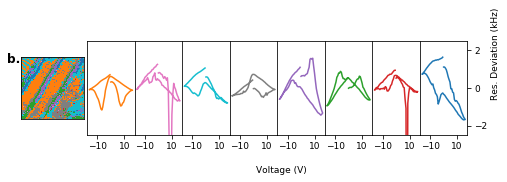

In [13]:
# plot the quick kmeans analysis
fig = plt.figure(figsize=(8,2))
gs = fig.add_gridspec(1, 1)

plot_all_kmeans(gs[0], clus_mean_removal, cent_mean_removal, labelpad=100, kwargs_text={'fontsize' : 9}, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold', 'color':'k'}, conv=[0,1,2,3,4,5,6,7])

### Pick behaviors that are "bad" and should be removed

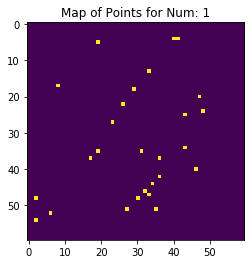

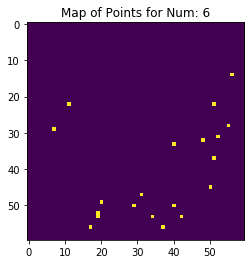

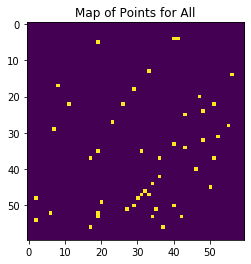

In [14]:
bad_list = [1,6]   # Chose "bad" behaviors from above, where 0 represents the left most behavior and 7 the right most.

remove = np.full((60,60),False)   # Initital "points to remove" flags

# For each identified bad behavior
for num in bad_list:

    # Find the points with said bad behavior
    bad_temp = clus_mean_removal == num
    
    # Plot them over the sample area for convience
    plt.figure()
    plt.imshow(bad_temp)
    
    plt.title('Map of Points for Num: '+str(num),)
    
    # Add points to the list of points to remove
    remove = np.logical_or(remove,bad_temp)

#plot all points over the sample area we are removing
plt.figure()
plt.imshow(remove)
plt.title('Map of Points for All')

flags = np.reshape(remove,(3600))

# Error Comparison

In [15]:
errors = [] # Store errors
#stack_vars = ['PR','Res']   # Which
# For various number of components
for global_n in [2,3,4,5,6,7,8,9]:

    # Data and voltage values
    stacked_dataset = second_data
    voltages = v_cycle

    # Grid size
    orig_shape = [60,60]
    
    # Run initial kmeans for seeding
    nclusters = global_n
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(stacked_dataset.values[~flags,:])
    clusters_2nd = kmeans.labels_#.reshape((orig_shape[0], orig_shape[1]))
    centroids_2nd = kmeans.cluster_centers_
    
    # Reformat Kmeans analysis so we can use it for seeding the dictionary learning analysis
    labels = clusters_2nd
    comp_init = np.zeros_like(centroids_2nd)
    lm_init = np.zeros((len(labels),global_n))
    for i in range(global_n):
        u = np.zeros_like(labels)
        u[labels==i] = 1
        lm_init[:,i] = u
        comp_init[i] = centroids_2nd[i]

    comps = []   # Where to save all of the resulting component
    maps = []    # Where to save all of the resulting maps

    # For the various listed alphas
    for alp in global_alp:
        
        #parameters for this run of the analysis
        orig_shape = [60,60]
        sparsity = alp
        iterations = 10000
        num_components = global_n
        stacked_dataset = second_data

        # remove points identified above
        dataset_analysis = stacked_dataset.values[~flags,:]

        # Set up DL model
        model = DictionaryLearning(n_components=num_components, code_init=lm_init, dict_init = comp_init, n_jobs=-1, max_iter=iterations, transform_algorithm='lasso_lars', alpha=sparsity, fit_algorithm='cd',positive_code=True, tol=1e-9)
        
        # Fit and get results
        DL_loading_maps = model.fit_transform(dataset_analysis)
        DL_components = model.components_
        
        #------- Normalize components so maps are from 0-1
        pr_len = int(DL_components.shape[1]/2)
        DL_components[:,:pr_len] = DL_components[:,:pr_len]/10
        #Normalize the Maps and components. For each component, divide the maps by the max value and multiply the components by this same value 
        for n in np.arange(0,num_components):
            map_data = DL_loading_maps[:,n]
            max_val = np.max(map_data)
            norm_map = map_data/max_val

            norm_comp = DL_components[n,:]*max_val

            DL_loading_maps[:,n] = norm_map
            DL_components[n,:] = norm_comp
        #----------

        # Add back the removed points as inf values
        temp = np.full((3600,global_n),np.inf)
        temp[~flags,:] = DL_loading_maps
        DL_loading_maps = temp

        # Save DL results
        comps.append(DL_components)
        maps.append(DL_loading_maps)
        
        
    #all_pr = pd.DataFrame(np.full((3600,len(global_alp)),0.0), index=stacked_dataset.index, columns = global_alp)
    #all_res = pd.DataFrame(np.full((3600,len(global_alp)),0.0), index=stacked_dataset.index, columns = global_alp)
    #initialize dataframe where we sill store the errors
    all_total = pd.DataFrame(np.full((3600,len(global_alp)),0.0), index=stacked_dataset.index, columns = global_alp)

    # For each alpha value - again
    for i, alp in enumerate(global_alp):
        
        #Grap the resulting maps/comps
        map_data = maps[i]
        comp_data = comps[i]

        # Reconstruct the data from the kmeans analysis
        recon =  map_data.dot(comp_data)
        recon_df = pd.DataFrame(recon, index=stacked_dataset.index, columns=stacked_dataset.columns)
        recon_df['PR'] = recon_df['PR']*10

        #pr_sse = ((recon_df['PR']-stacked_dataset['PR'])**2).sum(axis=1)
        #res_sse = ((recon_df['Res']-stacked_dataset['Res'])**2).sum(axis=1)
        total_sse = ((recon_df-stacked_dataset)**2).sum(axis=1)
        #full_sse = ((recon_df-stacked_dataset)**2)

        #all_pr[global_alp[i]] = pr_sse
        #all_res[global_alp[i]] = res_sse
        all_total[global_alp[i]] = total_sse
    
    # Save the errors
    errors.append(all_total)

# Convert the saved errors to a Dataframe
all_errors = pd.concat(errors,axis=1)
new_errors = pd.DataFrame(all_errors.values,index=all_errors.index, columns=pd.MultiIndex.from_product([np.arange(2,10), [1,6,12]],names=['Comps', 'Alp']))

In [18]:
errors

[              1           6           12
 Acq                                     
 0     122.896450  124.109942  124.900314
 1      33.428015   33.816660   34.739245
 2      21.820217   22.049184   22.555639
 3      25.089045   25.332756   26.155143
 4      18.820798   17.945477   15.838043
 ...          ...         ...         ...
 3595   81.012033   81.942297   84.559871
 3596   57.468529   58.172934   60.363089
 3597   50.376406   51.121331   53.137593
 3598   34.319050   34.954961   36.629090
 3599   29.104753   29.611817   30.850356
 
 [3600 rows x 3 columns],
               1           6           12
 Acq                                     
 0     119.308733  123.126980  126.620143
 1      26.635803   29.378072   35.312519
 2      18.990904   21.669291   23.984602
 3      22.222229   25.071758   27.623788
 4      17.669697   17.304140   16.150274
 ...          ...         ...         ...
 3595   51.307577   55.483968   78.751675
 3596   39.875302   41.419426   55.436575
 3597 

In [17]:
all_errors

,1,6,12,1,6,12,1,6,12,1,...,12,1,6,12,1,6,12,1,6,12
Acq,,,,,,,,,,,,,,,,,,,,,
0,122.896450,124.109942,124.900314,119.308733,123.126980,126.620143,108.490826,110.979905,118.673520,106.181448,...,109.060030,105.258006,108.356929,110.076211,105.923111,107.488731,107.748434,105.309152,107.520588,108.416939
1,33.428015,33.816660,34.739245,26.635803,29.378072,35.312519,20.912577,21.567484,26.479110,18.893788,...,21.243925,17.667344,18.993922,20.675892,17.841737,18.547307,20.086313,17.131670,18.607061,20.799128
2,21.820217,22.049184,22.555639,18.990904,21.669291,23.984602,17.424772,18.090650,19.506059,17.657924,...,17.676854,17.081254,17.770662,17.636869,16.021282,17.253589,17.098147,14.319864,17.311047,17.020756
3,25.089045,25.332756,26.155143,22.222229,25.071758,27.623788,18.662646,17.955621,23.285148,18.880786,...,17.312436,14.085332,15.971235,18.135134,15.321001,16.360779,17.612834,15.062698,16.587505,17.135278
4,18.820798,17.945477,15.838043,17.669697,17.304140,16.150274,13.444076,14.940158,16.626323,9.320249,...,10.147229,10.374484,11.077864,10.016188,8.212776,8.991943,10.259206,8.888042,9.272820,10.475497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,81.012033,81.942297,84.559871,51.307577,55.483968,78.751675,35.087191,50.687843,48.802618,29.045723,...,49.250509,25.082470,42.736136,38.133961,24.495472,41.888491,45.734139,26.093278,40.398047,44.259506
3596,57.468529,58.172934,60.363089,39.875302,41.419426,55.436575,28.537114,35.753480,37.937685,22.258297,...,36.147497,20.274851,28.416591,30.349683,18.356218,28.743179,34.271819,18.835022,28.226616,34.537550
3597,50.376406,51.121331,53.137593,28.414867,32.793045,50.915243,14.932395,24.485511,27.661773,9.100307,...,22.766703,8.118499,18.057375,18.533472,8.518536,17.241965,19.972080,7.965921,16.611833,19.798547


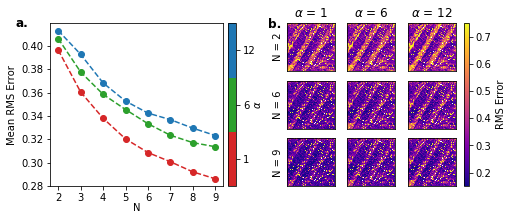

In [16]:
#Plot errors

from matplotlib.colors import LogNorm

idx = pd.IndexSlice

error_data = new_errors.loc[:,idx[:,1]]

length = recon_df.shape[1]
rms = np.sqrt(error_data/length).replace([np.inf,-np.inf],np.nan)
mean_rms = rms.mean(skipna=True)
std_rms = rms.std(skipna=True)


fig = plt.figure(figsize=(7.5,3))
gs = fig.add_gridspec(1, 2, width_ratios=[1,1],wspace=0.25)

gs_subline = gs[0].subgridspec(1, 2, width_ratios=[1,0.05],wspace=0.05)

ax_line = fig.add_subplot(gs_subline[0])

c = ['tab:red', 'tab:green', 'tab:blue']
cscale = matplotlib.colors.ListedColormap(c)
boundaries = np.arange(len(c)+1)-0.5+2
norm = matplotlib.colors.BoundaryNorm(boundaries, cscale.N, clip=True)


ax_cbar = fig.add_subplot(gs_subline[1])

bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8,9]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cscale,
                                norm=norm,
                                boundaries=boundaries,
                                #extend='both',
                                #extendfrac='auto',
                                ticks=bounds,
                                spacing='uniform',
                                orientation='vertical',
                                label=r'$\alpha$')

#cb3.ax.invert_yaxis() 

comp_map_list = [0,4,7]

for i in range(3):
    j = [1,6,12][i]
    error_data = new_errors.loc[:,idx[:,j]]

    length = recon_df.shape[1]
    rms = np.sqrt(error_data/length).replace([np.inf,-np.inf],np.nan)
    mean_rms = rms.mean(skipna=True)
    std_rms = rms.std(skipna=True)
    mean_rms

    ax_line.plot(np.arange(2,10),mean_rms.values,'.--', markersize=12, color=c[i], label=str(j))#, yerr=std_rms.values)
    ax_line.set_xlabel('N',labelpad=-0.4)
    ax_line.set_xticks(np.arange(2,10))
    #ax_line.set_xticklabels(['1','6','12'])
    ax_line.set_ylabel('Mean RMS Error')

ax_cbar.set_yticklabels(['1','6','12'])
ax_cbar.set_ylabel(r'$\alpha$',labelpad=-3)
ax_line.annotate('a.',(-0.2,0.975),xycoords='axes fraction', color='k',fontsize=12,fontweight='bold')
#ax_line.legend()

gs_maps = gs[1].subgridspec(3, 4,width_ratios = [1,1,1,0.08], wspace=0.1)

letter = ['b.','c.','d.','e.','f.','g.','h.','i.','j.']
comps_list = ['2','6','9']

for j, alp in enumerate([1,6,12]):
    for i, comps in enumerate(comp_map_list):
        error_data = errors[comps][alp]
        length = recon_df.shape[1]
        rms = np.sqrt(error_data/length).replace([np.inf,-np.inf],np.nan)
        ax = fig.add_subplot(gs_maps[i,j])
        im = ax.imshow(np.reshape(rms.values,(60,60)), cmap='plasma', interpolation='none' ,vmin=0.15, vmax=0.75)#norm=LogNorm(vmin=0.15, vmax=0.75)) #)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            #ax.annotate(letter[i],(-0.24,0.90),xycoords='axes fraction', color='k',fontsize=12,fontweight='bold')
            ax.set_ylabel('N = '+comps_list[i])
        if i == 0:
            ax.set_title(r'$\alpha$ = '+str(alp))
        if i == 0 and j == 0:
            ax.annotate('b.',(-0.4,0.90),xycoords='axes fraction', color='k',fontsize=12,fontweight='bold')

gs_cbar = gs_maps[:,3]
ax_c = fig.add_subplot(gs_cbar)
plt.colorbar(im, cax=ax_c, orientation='vertical', label='RMS Error')


In [18]:
fig.savefig(save_path+'error_analysis23456789_fixed.png', format='png', dpi=500)
fig.savefig(save_path+'error_analysis23456789_fixed.eps', format='eps', dpi=500)